# ディープラーニングフレームワーク PyTorch を利用した実装

In [61]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [62]:
# 訓練データをdatasetsからダウンロード
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# テストデータをdatasetsからダウンロード
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [63]:
epoch_num = 20  # エポック数を設定する
batch_size = 100  # バッチの数
learning_rate = 0.1  # 学習係数

In [64]:
# データローダーの作成
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([100, 1, 28, 28])
Shape of y:  torch.Size([100]) torch.int64


In [76]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# modelを定義します
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Sigmoid(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_sigmoid_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [78]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [82]:
def train(dataloader, model, loss_fn, optimizer):
    loss_list = []
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = torch.eye(10)[y]  # one-hot 表現に変換
        
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
    
    return loss_list

#        if batch % 100 == 0:
#            loss, current = loss.item(), batch * len(X)
#            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [84]:
def test(dataloader, model):
#    global train_loss_list
    size = len(dataloader.dataset)
    model.eval()  # 評価モード
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y = torch.eye(10)[y]  # one-hot 表現に変換
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
#            test_loss = loss_fn(pred, y).item()
#            train_loss_list.append(test_loss)
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
#    model.train()  # 訓練モード
    
    return test_loss, correct
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [85]:
train_loss_list = []
train_acc_list = [0.0]
test_acc_list = [0.0]

for t in range(epoch_num):
#    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_loss_list += train_loss
    train_loss, train_acc = test(train_dataloader, model)
#    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss, test_acc = test(test_dataloader, model)
    test_acc_list.append(test_acc)
    print('epoch(' + str(t + 1) + ') accuracy(train, test) = (' \
          + str(train_acc) + ', ' + str(test_acc) + ')')

print("Done!")

epoch(1) accuracy(train, test) = (0.8912833333333333, 0.8971)
epoch(2) accuracy(train, test) = (0.9035666666666666, 0.9068)
epoch(3) accuracy(train, test) = (0.9116166666666666, 0.9143)


KeyboardInterrupt: 

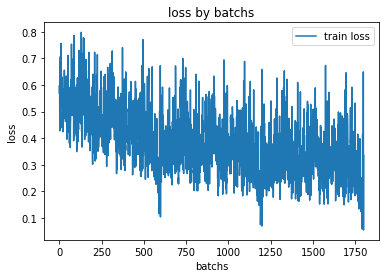

In [86]:
# グラフの描画
#x = np.arange(len(train_loss_list))
x = torch.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss')
plt.xlabel('batchs')
plt.ylabel('loss')
plt.title('loss by batchs')
plt.legend(loc='upper right')
plt.show()

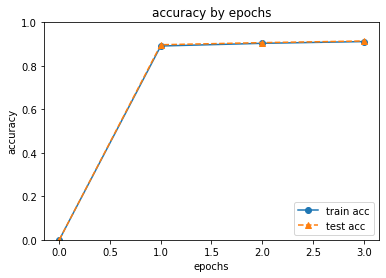

In [87]:
# グラフの描画
#x = np.arange(len(train_acc_list))
x = torch.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc', marker='o')
plt.plot(x, test_acc_list, label='test acc', linestyle='--', marker='^')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy by epochs')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [55]:
model.eval()
for batch, (X, y) in enumerate(test_dataloader):
    with torch.no_grad():
        test_result = model(X)
#        predicted, actual = pred[0].argmax(0), y
#        print(f'Predicted: "{predicted}", Actual: "{actual}"')
        print(pred.shape)
        for index in range(3):
            print(f'index = {index}')
            print(test_result[index])
            print(y[index])
    break

torch.Size([100, 10])
index = 0
tensor([-0.6292, -3.0379,  2.2769,  2.7341, -4.2460,  0.3668, -8.4951,  9.7019,
        -1.0103,  1.9404])
tensor(7)
index = 1
tensor([ 2.3303,  1.3277,  7.8088,  2.0250, -6.9515,  3.1725,  3.5517, -7.3518,
         0.4815, -7.3727])
tensor(2)
index = 2
tensor([-6.8673,  7.3218,  1.7671,  0.4447, -2.3768,  0.6664, -0.4621,  1.5314,
         0.6779, -2.5947])
tensor(1)
